<a href="https://colab.research.google.com/github/samikris/bloodpressureproject/blob/main/BloodPressureClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic data preparation**
1. Connect to gDrive to the folder with sheet and images
2. Install exifread (extract the image info/metadata)
3. get metadata for 1 image
4. Get metadata for all images in the GDrive Folder
5. Join it to the data collection spreadsheet
6. Charts for the data
7. Annotate Labels in spreadsheet for high BP based on reading
8. Crop images for eyes only

Merging the Eye Images to BP Using Dataframes:
1. Threshold systolic/diastolic data as high or low (0 or 1) for binary classification
2. Using datetime metadata extracted from images and connnect to datetime reading (with BP) from spreadsheet (with tolerances)


**Creating data for Neural Net**
1. Install fast.ai library
2. create the eyes training data set, connected to the dataframe with BP and images
- RANDOM 40% of images would be for training
- 15% for validation
- also created labels for binary classification in the network (0 and 1)
3. Each batch has 64 images to train on
4. Use the learner function to traing the network in 15 epochs, seemed to produce the best results from training

**Training**
1. Tracked loss and accuracy for 15 epochs (random iterations)
2. By 15th epoch, 91.67% accuracy was the highest

**Prediction**
1. Input brand new test images 1 by 1, see how close probabilities are to actual classification of the photo
2. ~60% accuracy
3. Major discrepancy between training and prediction, likely because the network is not good at generalizing and overfits the training data (essentially memorizes it)

**Future**
1. Implement batch augmentation
2. Collect more images
3. Split eyes to see if individual eyes indicate anything, produces more data


# Preparing Data

Step 1 - Connect to gDrive and the folder with sheets/images

In [ ]:
!pip3 install pillow-heif
from pillow_heif import register_heif_opener
register_heif_opener()

In [ ]:
import gspread as gs

In [ ]:
import pandas as pd #i am importing the pandas!
from google.colab import auth
from google.auth import default
from pathlib import Path
from PIL import Image

#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gs.authorize(creds)

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


# More Data Preparation

In [ ]:
import os


In [ ]:
!pip install 'exifread<3'

In [ ]:
#basically getting dates
import exifread


def getImageMeta(filepath):
  with open(filepath, 'rb') as f:
    tags = exifread.process_file(f)

    filename = Path(filepath).stem

    return {"filepath":filepath, "filename": filename, "metadata":tags['EXIF DateTimeOriginal']} #provides filepath, key (img_xxx), and ONLY DATEETIME




Get absolute path of all images and make it into a string so we can iterate through it and get metadata!

We want only the eyes in the images so we can use the computer vision library to crop.

In [ ]:

def convertJPEG(filepath, filename):
  image = Image.open(filepath)
  convertedfilepath = f"{dir}/{filename}.jpg"
  image.save(convertedfilepath, format = "jpeg") #converts every file that is passed into jpg
  img = Image.open(convertedfilepath)
  box = (350, 950, 1797, 1450)
  img2 = img.crop(box)
  finalfilepath = f"{dir}/{filename}_cropped.jpg"
  img2.save(finalfilepath)
  os.remove(convertedfilepath)
  return finalfilepath


In [ ]:
def processImage(dir):
  d = Path(dir)
  images = [str(f) for f in d.iterdir() if f.is_file() and ".jpg" not in str(f)] #only if the item is a file, then get its absolute path
  metalist = [getImageMeta(i) for i in images]
  for im in metalist:
    cfp = convertJPEG(im["filepath"],im["filename"])
    im["convertedpath"] = cfp
    print(im)
  return metalist

dir = "gdrive/MyDrive/ScienceFairProject/Images"
metalist=processImage(dir)

TIME TO CROP AFTER ALL THAT WORK!

In [ ]:
dir = "gdrive/MyDrive/ScienceFairProject/TestImages"
processImage(dir)


{'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0651.heic', 'filename': 'IMG_0651', 'metadata': (0x9003) ASCII=2023:03:18 22:33:36 @ 666, 'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0651_cropped.jpg'}
{'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0650.HEIC', 'filename': 'IMG_0650', 'metadata': (0x9003) ASCII=2023:03:18 22:33:27 @ 630, 'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0650_cropped.jpg'}
{'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0656.heic', 'filename': 'IMG_0656', 'metadata': (0x9003) ASCII=2023:03:19 09:29:42 @ 666, 'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0656_cropped.jpg'}
{'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0655.HEIC', 'filename': 'IMG_0655', 'metadata': (0x9003) ASCII=2023:03:19 08:49:56 @ 630, 'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0655_cropped.jpg'}
{'filepath': 'gdrive/MyDrive/ScienceFairProj

[{'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0651.heic',
  'filename': 'IMG_0651',
  'metadata': (0x9003) ASCII=2023:03:18 22:33:36 @ 666,
  'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0651_cropped.jpg'},
 {'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0650.HEIC',
  'filename': 'IMG_0650',
  'metadata': (0x9003) ASCII=2023:03:18 22:33:27 @ 630,
  'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0650_cropped.jpg'},
 {'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0656.heic',
  'filename': 'IMG_0656',
  'metadata': (0x9003) ASCII=2023:03:19 09:29:42 @ 666,
  'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0656_cropped.jpg'},
 {'filepath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0655.HEIC',
  'filename': 'IMG_0655',
  'metadata': (0x9003) ASCII=2023:03:19 08:49:56 @ 630,
  'convertedpath': 'gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0655_cropped.jpg'},
 {'filepath'

Create the data frames using pandas

Open google [spreadsheet](https://docs.google.com/spreadsheets/d/15yaBVHdAkeWrsezA36AHNmNKLFmJjVR9I429pRrhVk4/edit#gid=0 ) with the data we need

In [ ]:
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/15yaBVHdAkeWrsezA36AHNmNKLFmJjVR9I429pRrhVk4/edit#gid=0')
worksheet = sh.get_worksheet(0)
df = pd.DataFrame(worksheet.get_all_records())
df["dt"] = pd.to_datetime(df["dt"])
df.sort_values("dt",inplace = True)
df


,Date,Time,Systolic BPM,Diastolic BPM,Pic,Food within the hour,Exercise,Comments,label,dt,is_valid
0,01/28/2023,17:00,138,83,,,None,,1,2023-01-28 17:00:00,FALSE
1,01/28/2023,18:30,97,64,,,Rowing,,0,2023-01-28 18:30:00,FALSE
2,01/29/2023,7:38,121,74,,,Yoga,,0,2023-01-29 07:38:00,FALSE
3,01/29/2023,19:47,133,83,,,,Indian food from SV,1,2023-01-29 19:47:00,FALSE
4,01/30/2023,8:05,116,71,,coffee,None,,0,2023-01-30 08:05:00,FALSE
5,01/30/2023,9:54,104,67,,,Rowing,,0,2023-01-30 09:54:00,FALSE
6,02/06/2023,11:45,143,87,,"coffee, fried rice",None,,1,2023-02-06 11:45:00,FALSE
7,02/06/2023,13:00,94,56,,,Rowing 35min,,0,2023-02-06 13:00:00,TRUE
8,02/06/2023,19:00,112,69,,,,,0,2023-02-06 19:00:00,FALSE
9,02/07/2023,7:00,113,69,,,,,0,2023-02-07 07:00:00,FALSE


Create a second dataframe from the metadata

In [ ]:
metadf = pd.DataFrame.from_dict(metalist)
metadf['metadata']

,metadata
0,2023:01:27 16:48:15
1,2023:01:27 16:48:18
2,2023:01:22 09:01:55
3,2023:01:22 09:01:53
4,2023:01:17 07:49:02
...,...
64,2023:02:23 09:00:12
65,2023:03:08 19:47:11
66,2023:02:28 08:01:16
67,2023:02:26 21:14:28


In [ ]:
type(metadf["metadata"])
metadf["dt"] = pd.to_datetime(metadf["metadata"], format = "%Y:%m:%d %H:%M:%S")
metadf.sort_values("dt",inplace = True)
metadf

,filepath,filename,metadata,convertedpath,dt
5,gdrive/MyDrive/ScienceFairProject/Images/IMG_0318.HEIC,IMG_0318,2023:01:17 07:48:53,gdrive/MyDrive/ScienceFairProject/Images/IMG_0318_cropped.jpg,2023-01-17 07:48:53
4,gdrive/MyDrive/ScienceFairProject/Images/IMG_0319.HEIC,IMG_0319,2023:01:17 07:49:02,gdrive/MyDrive/ScienceFairProject/Images/IMG_0319_cropped.jpg,2023-01-17 07:49:02
3,gdrive/MyDrive/ScienceFairProject/Images/IMG_0322.HEIC,IMG_0322,2023:01:22 09:01:53,gdrive/MyDrive/ScienceFairProject/Images/IMG_0322_cropped.jpg,2023-01-22 09:01:53
2,gdrive/MyDrive/ScienceFairProject/Images/IMG_0323.HEIC,IMG_0323,2023:01:22 09:01:55,gdrive/MyDrive/ScienceFairProject/Images/IMG_0323_cropped.jpg,2023-01-22 09:01:55
7,gdrive/MyDrive/ScienceFairProject/Images/IMG_0324.HEIC,IMG_0324,2023:01:22 09:01:57,gdrive/MyDrive/ScienceFairProject/Images/IMG_0324_cropped.jpg,2023-01-22 09:01:57
...,...,...,...,...,...
55,gdrive/MyDrive/ScienceFairProject/Images/IMG_0599.heic,IMG_0599,2023:02:26 21:14:25,gdrive/MyDrive/ScienceFairProject/Images/IMG_0599_cropped.jpg,2023-02-26 21:14:25
67,gdrive/MyDrive/ScienceFairProject/Images/IMG_0600.HEIC,IMG_0600,2023:02:26 21:14:28,gdrive/MyDrive/ScienceFairProject/Images/IMG_0600_cropped.jpg,2023-02-26 21:14:28
66,gdrive/MyDrive/ScienceFairProject/Images/IMG_0603.HEIC,IMG_0603,2023:02:28 08:01:16,gdrive/MyDrive/ScienceFairProject/Images/IMG_0603_cropped.jpg,2023-02-28 08:01:16
68,gdrive/MyDrive/ScienceFairProject/Images/IMG_0607.HEIC,IMG_0607,2023:03:03 07:48:13,gdrive/MyDrive/ScienceFairProject/Images/IMG_0607_cropped.jpg,2023-03-03 07:48:13


In [ ]:
#save this csv to my files!
merged_df = pd.merge_asof(metadf,df, on = "dt",tolerance = pd.Timedelta("3h"), direction = "nearest")
merged_df["label"] = merged_df["label"].astype("Int64")
filtered_df = merged_df[merged_df["label"].notnull()][["convertedpath","label"]]
filtered_df.rename({"convertedpath":"path"},inplace=True, axis=1)
getlabel=lambda path: filtered_df.query(f'"{str(path)}" == path')["label"].item() #anonymous

filtered_df = filtered_df.astype({"label":"str"})
filtered_df.dtypes
filtered_df

,path,label
16,gdrive/MyDrive/ScienceFairProject/Images/IMG_0345_cropped.jpg,0
17,gdrive/MyDrive/ScienceFairProject/Images/IMG_0346_cropped.jpg,0
18,gdrive/MyDrive/ScienceFairProject/Images/IMG_0347_cropped.jpg,0
19,gdrive/MyDrive/ScienceFairProject/Images/IMG_0348_cropped.jpg,0
20,gdrive/MyDrive/ScienceFairProject/Images/IMG_0349_cropped.jpg,0
21,gdrive/MyDrive/ScienceFairProject/Images/IMG_0350_cropped.jpg,0
22,gdrive/MyDrive/ScienceFairProject/Images/IMG_0351_cropped.jpg,1
23,gdrive/MyDrive/ScienceFairProject/Images/IMG_0352_cropped.jpg,1
24,gdrive/MyDrive/ScienceFairProject/Images/IMG_0353_cropped.jpg,1
25,gdrive/MyDrive/ScienceFairProject/Images/IMG_0355_cropped.jpg,0


In [ ]:
# FROM CLAUDE - relearn!!
# Your existing code (from the screenshot)
merged_df = pd.merge_asof(metadf, df, on="dt", tolerance=pd.Timedelta("3h"), direction="nearest")
merged_df["label"] = merged_df["label"].astype("Int64")
filtered_df = merged_df[merged_df["label"].notnull()][["convertedpath", "label"]]
filtered_df.rename({"convertedpath": "path"}, inplace=True, axis=1)

# Extract just the filename from the full path
filtered_df['filename'] = filtered_df['path'].apply(lambda x: x.split('/')[-1])

# Create final dataframe with just filename and label
final_df = filtered_df[['filename', 'label']].copy()

# Convert label to string if needed
final_df = final_df.astype({"label": "str"})

# Save to CSV
final_df.to_csv('image_labels.csv', index=False)

print("CSV saved!")
print(final_df.head())

CSV saved!
                filename label
16  IMG_0345_cropped.jpg     0
17  IMG_0346_cropped.jpg     0
18  IMG_0347_cropped.jpg     0
19  IMG_0348_cropped.jpg     0
20  IMG_0349_cropped.jpg     0


In [ ]:
# FROM CLAUDE
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save your CSV to Google Drive
final_df.to_csv('/content/drive/MyDrive/image_labels.csv', index=False)
print("CSV saved to Google Drive!")

Mounted at /content/drive
CSV saved to Google Drive!


# Building a Neural Network

Preparing images based on paths we extracted above

In [ ]:
getlabel(Path('gdrive/MyDrive/ScienceFairProject/Images/IMG_0595_cropped.jpg'))

'1'

In [ ]:
eyes = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSubsetSplitter(train_sz=0.4, valid_sz=0.15, seed=42),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   batch_tfms=aug_transforms())


In [ ]:
dls =  eyes.dataloaders(filtered_df, bs=8)

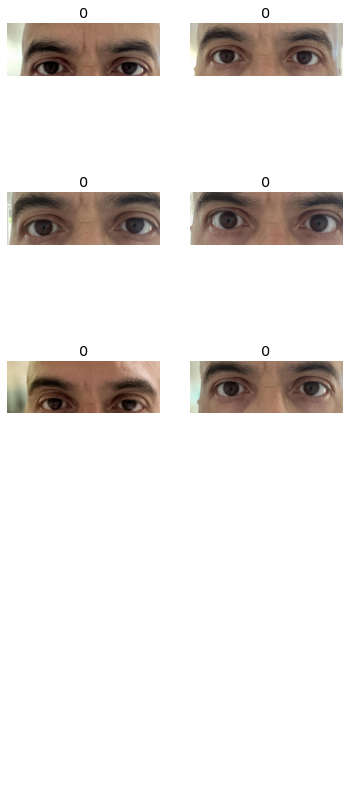

In [ ]:
dls.valid.show_batch(max_n=10, nrows=5)

# Learning

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)
learn.fine_tune(15) #15 epochs



/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.932579,0.941172,0.500000,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,1.181214,0.721096,0.666667,00:02
1,1.090257,0.704617,0.583333,00:02
2,1.006137,0.614307,0.666667,00:02
3,0.913997,0.507204,0.750000,00:02
4,0.931625,0.493657,0.833333,00:02
5,0.907109,0.526853,0.833333,00:02
6,0.873568,0.469230,0.750000,00:02
7,0.812333,0.373959,0.833333,00:03
8,0.769955,0.255770,1.000000,00:02
9,0.736548,0.164626,1.000000,00:02


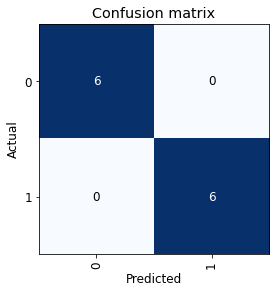

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict("gdrive/MyDrive/ScienceFairProject/TestImages/IMG_0657_cropped.jpg")


((#1) ['1'], TensorBase([False,  True]), TensorBase([0.1261, 0.7895]))